In [53]:
!pip install pymannkendall

In [54]:
import geopandas as gpd
import folium
import ee  # Earth Engineライブラリ
from google.colab import drive
import json
from shapely.geometry import mapping
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.linear_model import LinearRegression
import pymannkendall as mk

In [55]:
drive.mount("/content/drive/")
input_dir = "GIS_Related_Study/NagoyaU_2025_RS/衛星データ/INPUT/"
input_path = "/content/drive/MyDrive/" + input_dir
output_dir = "GIS_Related_Study/NagoyaU_2025_RS/衛星データ/OUTPUT/"
output_path = "/content/drive/MyDrive/" + output_dir

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [76]:
# メコン川のシェープファイルのパス
mekong_shp_path = input_path + "mekong4/Mekong_River_Full.shp"
# シェープファイルを読み込み
mekong_gdf = gpd.read_file(mekong_shp_path)
# WRS-2のシェープファイルのパス
wrs2_shp_path = input_path + "WRS2/WRS2_descending.shp"
# シェープファイルを読み込み
wrs2_gdf = gpd.read_file(wrs2_shp_path)

In [77]:
# メコン川データの座標系を確認し、必要に応じて変換
if mekong_gdf.crs.to_string() != "EPSG:4326":
    mekong_gdf = mekong_gdf.to_crs(epsg=4326)
# WRS-2データの座標系を確認し、必要に応じて変換
if wrs2_gdf.crs.to_string() != "EPSG:4326":
    wrs2_gdf = wrs2_gdf.to_crs(epsg=4326)

In [78]:
# 対象とするPATH/ROWを選択
selected_area_paths_row = wrs2_gdf[
    (wrs2_gdf['PATH'] == 130) & (wrs2_gdf['ROW'] == 46)
]
# メコン川のデータを選択した領域でクリップ
mekong_area_clip = gpd.clip(mekong_gdf, selected_area_paths_row)

In [86]:
# バッファ距離を設定（単位はメートル）
buffer_distance = 5000  # 例: 7000メートル
# 適切な投影法に変換（例: UTMゾーン48N）
mekong_area_clip = mekong_area_clip.to_crs(epsg=32648)
# バッファポリゴンを作成
mekong_buffer = mekong_area_clip.buffer(buffer_distance)
# バッファポリゴンをGeoDataFrameに変換
buffer_gdf = gpd.GeoDataFrame(geometry=mekong_buffer, crs=mekong_area_clip.crs)
# 元の座標系（EPSG:4326）に再投影
buffer_gdf = buffer_gdf.to_crs(epsg=4326)


In [80]:
ee.Authenticate()
ee.Initialize(project='ee-takeofuture')  # ご自身のプロジェクトIDを入力してください

In [87]:
# buffer_gdfをGeoJSON形式に変換
buffer_geojson = json.loads(buffer_gdf.to_json())
# GeoJSONからEarth Engineのジオメトリに変換
buffer_geometry = ee.Geometry(buffer_geojson['features'][3]['geometry'])
# GeoDataFrame を GeoJSON 形式の文字列に変換
#buffer_geojson_str = buffer_gdf.to_json()
# GeoJSON 文字列を辞書型に変換
#buffer_geojson_dict = json.loads(buffer_geojson_str)
# GeoJSON 辞書を Earth Engine の FeatureCollection に変換
#buffer_fc = ee.FeatureCollection(buffer_geojson_dict)
# FeatureCollection のジオメトリを取得
#buffer_geometry = buffer_fc.geometry()

In [88]:
# 例: buffer_gdf の3番目のフィーチャー（インデックス 2）だけを選択
selected_buffer = buffer_gdf.iloc[[3]]
selected_buffer_geojson = json.loads(selected_buffer.to_json())

# Foliumマップの作成（選択した領域の中心を指定）
map_center = [selected_buffer.geometry.centroid.y.mean(), selected_buffer.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB Positron')

# 選択したバッファ領域のみ表示（青色）
folium.GeoJson(
    selected_buffer_geojson,
    name="Selected Buffer Geometry",
    style_function=lambda feature: {'color': 'blue', 'fillOpacity': 0.3}
).add_to(m)

# WRS2 の選択領域（PATH=130, ROW=46）の GeoDataFrame を GeoJSON に変換
selected_area_geojson = json.loads(selected_area_paths_row.to_json())

# WRS2 の選択領域を境界線のみ（赤）で追加
folium.GeoJson(
    selected_area_geojson,
    name="Selected WRS2 Boundary",
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0}
).add_to(m)

# レイヤーコントロールを追加
folium.LayerControl().add_to(m)

# マップの表示
m

<ipython-input-88-dd0d1c3fc9f8>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [selected_buffer.geometry.centroid.y.mean(), selected_buffer.geometry.centroid.x.mean()]


In [89]:
# Landsat 5のデータを取得
landsat5 = (ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA')
                    .filterBounds(buffer_geometry)
                    .filterDate('1986-01-01', '2000-01-01')
                    .map(lambda image: image.clip(buffer_geometry)))
# Landsat 5のデータを取得
landsat5_1987 = (ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA')
            .filterBounds(buffer_geometry)
            .filterDate('1987-01-01', '1987-12-31')
            .median()
            .clip(buffer_geometry))
# Landsat 5のデータを取得
landsat5_1994 = (ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA')
            .filterBounds(buffer_geometry)
            .filterDate('1994-01-01', '1994-12-31')
            .median()
            .clip(buffer_geometry))


In [117]:
print(landsat5.filterDate('1980-01-01', '1985-12-31').size().getInfo())
print(landsat5.filterDate('1986-01-01', '1986-12-31').size().getInfo())
print(landsat5.filterDate('1987-01-01', '1987-12-31').size().getInfo())
print(landsat5.filterDate('1988-01-01', '1988-12-31').size().getInfo())
print(landsat5.filterDate('1989-01-01', '1989-12-31').size().getInfo())
print(landsat5.filterDate('1990-01-01', '1990-12-31').size().getInfo())
print(landsat5.filterDate('1994-01-01', '1994-12-31').size().getInfo())
print(landsat5.filterDate('1999-01-01', '1999-12-31').size().getInfo())

0
0
1
10
11
16
17
14


In [91]:
# Landsat 5の場合はバンド NDWI ['B3', 'B5'], MNDWI ['B3', 'B5']
# Landsat 5のImageCollectionに対して、NDWIを計算し、撮影日プロパティをセットする関数
def calcNDWI(image):
    ndwiImage = image.normalizedDifference(['B3', 'B5']).rename('NDWI')
    # 入力画像から 'system:time_start' プロパティを引き継ぐ
    return ndwiImage.set('system:time_start', image.get('system:time_start'))
# 同様に、MNDWIを計算する関数
def calcMNDWI(image):
    mndwiImage = image.normalizedDifference(['B2', 'B5']).rename('MNDWI')
    return mndwiImage.set('system:time_start', image.get('system:time_start'))

# Landsat 5のデータから各シーンごとにNDWIとMNDWIを計算し、日付プロパティを保持
ndwi = landsat5.map(calcNDWI)
mndwi = landsat5.map(calcMNDWI)

# Landsat 5の場合はバンド NDWI ['B3', 'B5'], MNDWI ['B3', 'B5']
ndwi1987 = landsat5_1987.normalizedDifference(['B3', 'B5']).rename('NDWI_1987')
mndwi1987 = landsat5_1987.normalizedDifference(['B2', 'B5']).rename('MNDWI_1987')
ndwi1994 = landsat5_1994.normalizedDifference(['B3', 'B5']).rename('NDWI_1994')
mndwi1994 = landsat5_1994.normalizedDifference(['B2', 'B5']).rename('MNDWI_1994')

In [92]:
# NDWI画像に対して、値が0以上の部分だけを残すマスクを適用する関数
def maskNDWI(image):
    return image.updateMask(image.gte(0))

# MNDWI画像に対して、値が0以上の部分だけを残すマスクを適用する関数
def maskMNDWI(image):
    return image.updateMask(image.gte(0))

# 各画像に対してマスクを適用（ImageCollection全体に map() で適用）
ndwi_masked = ndwi.map(maskNDWI)
mndwi_masked = mndwi.map(maskMNDWI)

# 0以上の部分のみ表示するためのマスクを適用
ndwi1987_masked = ndwi1987.updateMask(ndwi1987.gte(0))
mndwi1987_masked = mndwi1987.updateMask(mndwi1987.gte(0))
ndwi1994_masked = ndwi1994.updateMask(ndwi1994.gte(0))
mndwi1994_masked = mndwi1994.updateMask(mndwi1994.gte(0))

In [93]:
# 例：1987年の最後の画像を取得する場合
ndwi_1987 = ndwi_masked.filterDate('1987-01-01', '1987-12-31') \
                        .sort('system:time_start', False).first()
# 例：1994年の最初の画像を取得する場合
ndwi_1994 = ndwi_masked.filterDate('1994-01-01', '1994-12-31') \
                        .sort('system:time_start').first()
# 例：1987年の最後の画像を取得する場合
mndwi_1987 = mndwi_masked.filterDate('1987-01-01', '1987-12-31') \
                        .sort('system:time_start', False).first()
# 例：1994年の最初の画像を取得する場合
mndwi_1994 = mndwi_masked.filterDate('1994-01-01', '1994-12-31') \
                        .sort('system:time_start').first()
# 1985年の最後の画像の日付を取得する例
date_1987 = ee.Date(ndwi_1987.get('system:time_start')).format('YYYY-MM-dd').getInfo()
print('1985年 最後の画像の日付:', date_1987)
# 1994年の最初の画像の日付を取得する例
date_1994 = ee.Date(ndwi_1994.get('system:time_start')).format('YYYY-MM-dd').getInfo()
print('1994年 最初の画像の日付:', date_1994)

1985年 最後の画像の日付: 1987-12-16
1994年 最初の画像の日付: 1994-01-17


In [94]:
# 各画像の可視化パラメータ設定
# ndwi_1986 を緑系で表示（例：薄緑～濃緑）
ndwi1987Params = {'min': -0.5, 'max': 1, 'palette': ['#ccffcc', '#66ff66', '#00ff00']}
# ndwi_1994 を赤系で表示（例：薄赤～濃赤）
ndwi1994Params = {'min': -0.5, 'max': 1, 'palette': ['#ffcccc', '#ff6666', '#ff0000']}

# Foliumマップの作成（バッファ領域の中心を指定）
map_center = [buffer_gdf.geometry.centroid.y.mean(), buffer_gdf.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB Positron')

# Earth EngineのイメージをFoliumに追加するためのヘルパー関数
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# FoliumのMapクラスにメソッドを追加
folium.Map.add_ee_layer = add_ee_layer

# 選択したバッファ領域のみ表示（青色）
folium.GeoJson(
    selected_buffer_geojson,
    name="Selected Buffer Geometry",
    style_function=lambda feature: {'color': 'blue', 'fillOpacity': 0.3}
).add_to(m)

# WRS2 の選択領域を境界線のみ（赤）で追加
folium.GeoJson(
    selected_area_geojson,
    name="Selected WRS2 Boundary",
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0}
).add_to(m)
# 次に、1986年と1994年のNDWI（マスク済み）レイヤーをそれぞれ追加
m.add_ee_layer(ndwi1987_masked, ndwi1987Params, 'NDWI 1987')
m.add_ee_layer(ndwi1994_masked, ndwi1994Params, 'NDWI 1994')

# レイヤーコントロールを追加
folium.LayerControl().add_to(m)

# マップの表示
m

<ipython-input-94-bf7c387668a3>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [buffer_gdf.geometry.centroid.y.mean(), buffer_gdf.geometry.centroid.x.mean()]


In [98]:
# 各画像の可視化パラメータ設定
# ndwi_1986 を緑系で表示（例：薄緑～濃緑）
ndwi1987Params = {'min': -0.5, 'max': 1, 'palette': ['#ccffcc', '#66ff66', '#00ff00']}
# ndwi_1994 を赤系で表示（例：薄赤～濃赤）
ndwi1994Params = {'min': -0.5, 'max': 1, 'palette': ['#ffcccc', '#ff6666', '#ff0000']}

# Foliumマップの作成（バッファ領域の中心を指定）
map_center = [buffer_gdf.geometry.centroid.y.mean(), buffer_gdf.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB Positron')

# Earth EngineのイメージをFoliumに追加するためのヘルパー関数
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# FoliumのMapクラスにメソッドを追加
folium.Map.add_ee_layer = add_ee_layer

# 選択したバッファ領域のみ表示（青色）
folium.GeoJson(
    selected_buffer_geojson,
    name="Selected Buffer Geometry",
    style_function=lambda feature: {'color': 'blue', 'fillOpacity': 0.3}
).add_to(m)

# WRS2 の選択領域を境界線のみ（赤）で追加
folium.GeoJson(
    selected_area_geojson,
    name="Selected WRS2 Boundary",
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0}
).add_to(m)

# 次に、1986年と1994年のNDWI（マスク済み）レイヤーをそれぞれ追加
m.add_ee_layer(mndwi1987_masked, ndwi1987Params, 'MNDWI 1987')
m.add_ee_layer(mndwi1994_masked, ndwi1994Params, 'MNDWI 1994')

# レイヤーコントロールを追加
folium.LayerControl().add_to(m)

# マップの表示
m

<ipython-input-98-e3b7789945f1>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [buffer_gdf.geometry.centroid.y.mean(), buffer_gdf.geometry.centroid.x.mean()]


In [99]:
# 各画像から水域面積と撮影日を抽出する関数
def computeWaterArea(image):
    # すでに ndwi_masked は値が0以上の部分のみ残っているので、
    # 再度 gte(0) を使ってバイナリマスクを作成（あるいはそのまま利用してもよい）
    water_mask = image.gte(0).rename('water_mask')
    # 各ピクセルの面積（平方メートル）を計算
    pixel_area = ee.Image.pixelArea()
    # 水域ピクセルの面積を算出する画像を作成
    water_area_image = water_mask.multiply(pixel_area).rename('water_area')
    # 指定領域（buffer_geometry）内の水域面積の総和を計算（scaleは30m）
    water_area_dict = water_area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=buffer_geometry,
        scale=30,
        maxPixels=1e9
    )
    # 水域面積（平方メートル）を取得。画像によっては値が存在しない場合があるので ee.Number() によるキャスト
    water_area = ee.Number(water_area_dict.get('water_area'))
    # 撮影日の取得（'system:time_start' プロパティがセットされている前提）
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    # Feature として返す（プロパティに日付と水域面積をセット）
    return ee.Feature(None, {'date': date, 'water_area': water_area})

In [100]:
# ndwi_masked は日付付きの NDWI のマスク済み ImageCollection
water_features_ndwi = ndwi_masked.map(computeWaterArea)
# FeatureCollection を Python 側にリストとして取得
water_list_ndwi = water_features_ndwi.getInfo()['features']
# ndwi_masked は日付付きの NDWI のマスク済み ImageCollection
water_features_mndwi = mndwi_masked.map(computeWaterArea)
# FeatureCollection を Python 側にリストとして取得
water_list_mndwi = water_features_mndwi.getInfo()['features']


In [101]:
data = []
for f in water_list_ndwi:
    props = f['properties']
    # None チェック：水域面積が取得できない場合があるので
    if props['water_area'] is not None:
        # 水域面積は平方メートルなので、平方キロメートルに変換
        water_area_sqkm = props['water_area'] / 1e6
    else:
        water_area_sqkm = None
    data.append({'date': props['date'], 'water_area_sqkm': water_area_sqkm})

# Pandas DataFrame に変換
df_ndwi = pd.DataFrame(data)

data = []
for f in water_list_mndwi:
    props = f['properties']
    # None チェック：水域面積が取得できない場合があるので
    if props['water_area'] is not None:
        # 水域面積は平方メートルなので、平方キロメートルに変換
        water_area_sqkm = props['water_area'] / 1e6
    else:
        water_area_sqkm = None
    data.append({'date': props['date'], 'water_area_sqkm': water_area_sqkm})

# Pandas DataFrame に変換
df_mndwi = pd.DataFrame(data)

print(df_ndwi)
print(df_mndwi)

           date  water_area_sqkm
0    1987-12-16        75.651233
1    1988-01-17        59.944164
2    1988-02-02        46.540307
3    1988-04-06        97.543172
4    1988-05-24        63.853967
..          ...              ...
149  1999-10-30       392.122652
150  1999-11-15        57.899541
151  1999-12-01        58.572445
152  1999-12-17        58.360038
153  1996-09-10         0.000000

[154 rows x 2 columns]
           date  water_area_sqkm
0    1987-12-16       108.305498
1    1988-01-17        97.124155
2    1988-02-02        58.535335
3    1988-04-06       208.628721
4    1988-05-24        69.166148
..          ...              ...
149  1999-10-30       483.594334
150  1999-11-15        66.442520
151  1999-12-01        65.586529
152  1999-12-17        79.434392
153  1996-09-10         0.000000

[154 rows x 2 columns]


### プロットと移動平均グラフ(NDWI)

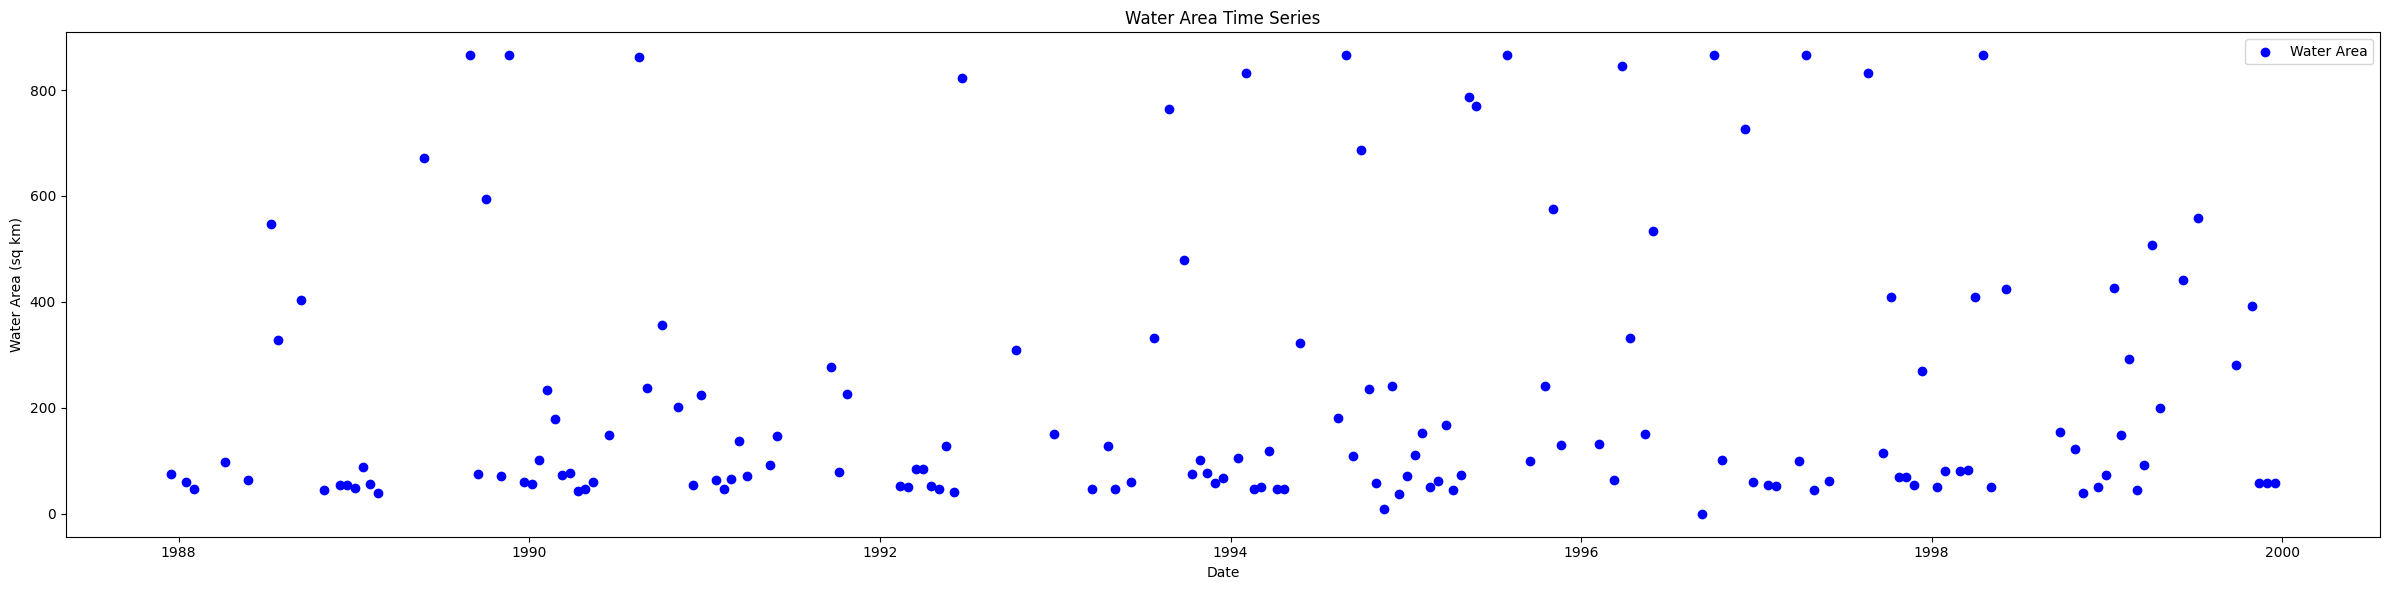

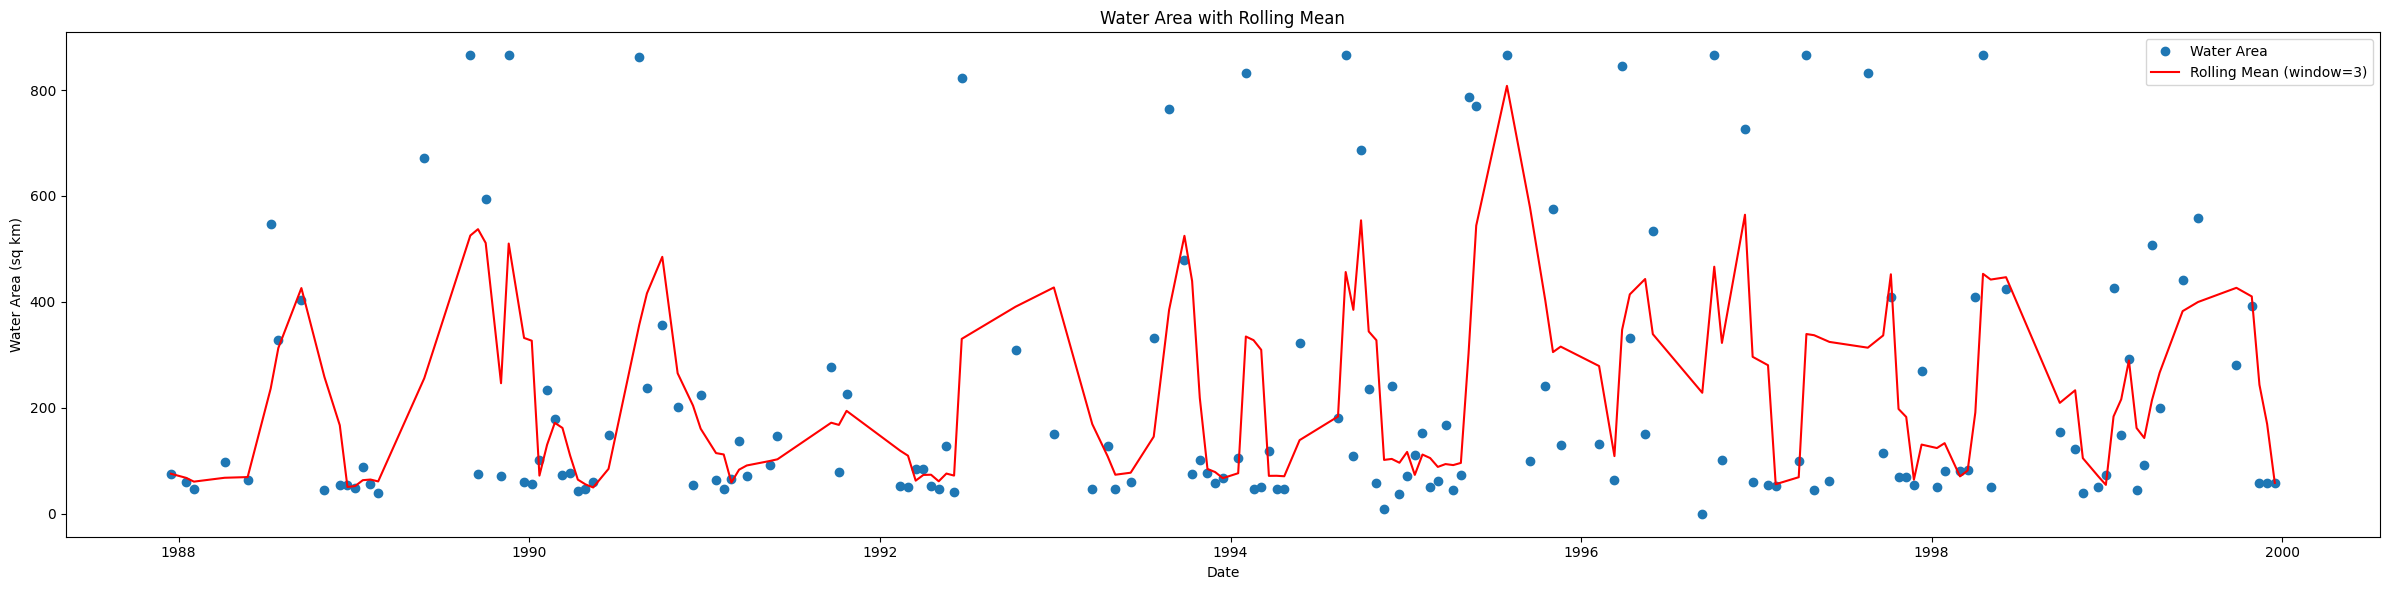

In [102]:
# df_ndwi に 'date' 列と 'water_area_sqkm' 列がある前提
df = df_ndwi.copy()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# 元データのプロット
plt.figure(figsize=(24,6))
plt.scatter(df.index, df['water_area_sqkm'], label='Water Area', color='blue')
plt.title('Water Area Time Series')
plt.xlabel('Date')
plt.ylabel('Water Area (sq km)')
plt.legend()
plt.tight_layout()
plt.show()

# 移動平均（例：3シーンのローリング平均）を計算してプロット
df['rolling_mean'] = df['water_area_sqkm'].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(24,6))
plt.plot(df.index, df['water_area_sqkm'], marker='o', linestyle='', label='Water Area')
plt.plot(df.index, df['rolling_mean'], color='red', label='Rolling Mean (window=3)')
plt.title('Water Area with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Water Area (sq km)')
plt.legend()
plt.tight_layout()
plt.show()


### 季節分解 (Seasonal Decomposition)

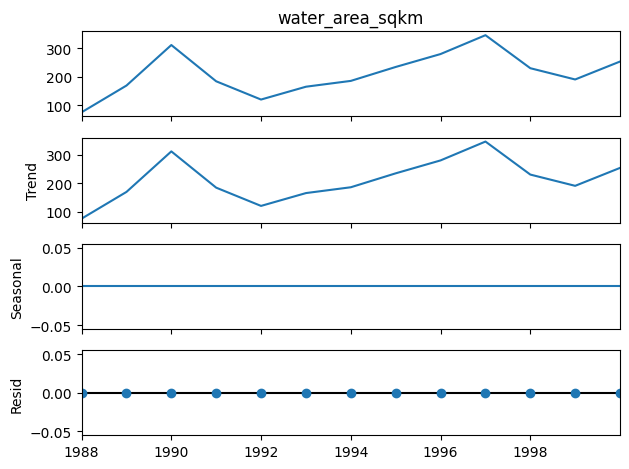

In [103]:
# 数値カラム 'water_area_sqkm' のみを選択して、年毎（'YE'）にリサンプリング
df_yearly = df[['water_area_sqkm']].resample('YE').mean()

# 季節分解（ここでは加法モデルを使用）
decomposition = seasonal_decompose(df_yearly['water_area_sqkm'], model='additive')
decomposition.plot()
plt.tight_layout()
plt.show()

### 線形回帰によるトレンド推定

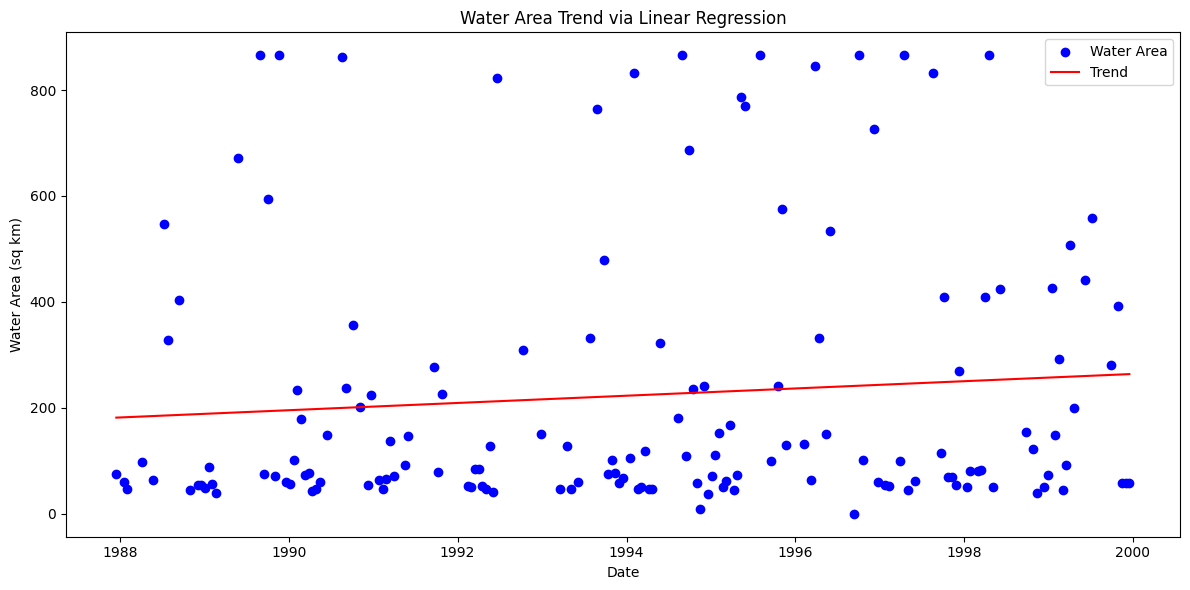

In [104]:
# 日付を数値に変換（例: オーディナル値）
df['ordinal'] = df.index.map(pd.Timestamp.toordinal)

X = df[['ordinal']]
y = df['water_area_sqkm']

model = LinearRegression()
model.fit(X, y)

# トレンドの予測値を計算
df['trend'] = model.predict(X)

plt.figure(figsize=(12,6))
plt.scatter(df.index, y, label='Water Area', color='blue')
plt.plot(df.index, df['trend'], color='red', label='Trend')
plt.title('Water Area Trend via Linear Regression')
plt.xlabel('Date')
plt.ylabel('Water Area (sq km)')
plt.legend()
plt.tight_layout()
plt.show()

### トレンド検定 (Mann-Kendall 検定)

In [112]:
# df_yearly など、一定の頻度にリサンプリングされた時系列データに対して実施
result = mk.original_test(df_yearly['water_area_sqkm'].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.05858757531048897, z=1.8912755158683454, Tau=0.41025641025641024, s=32.0, var_s=268.6666666666667, slope=10.68320755851571, intercept=169.50092069299646)


### プロットと移動平均グラフ(MNDWI)

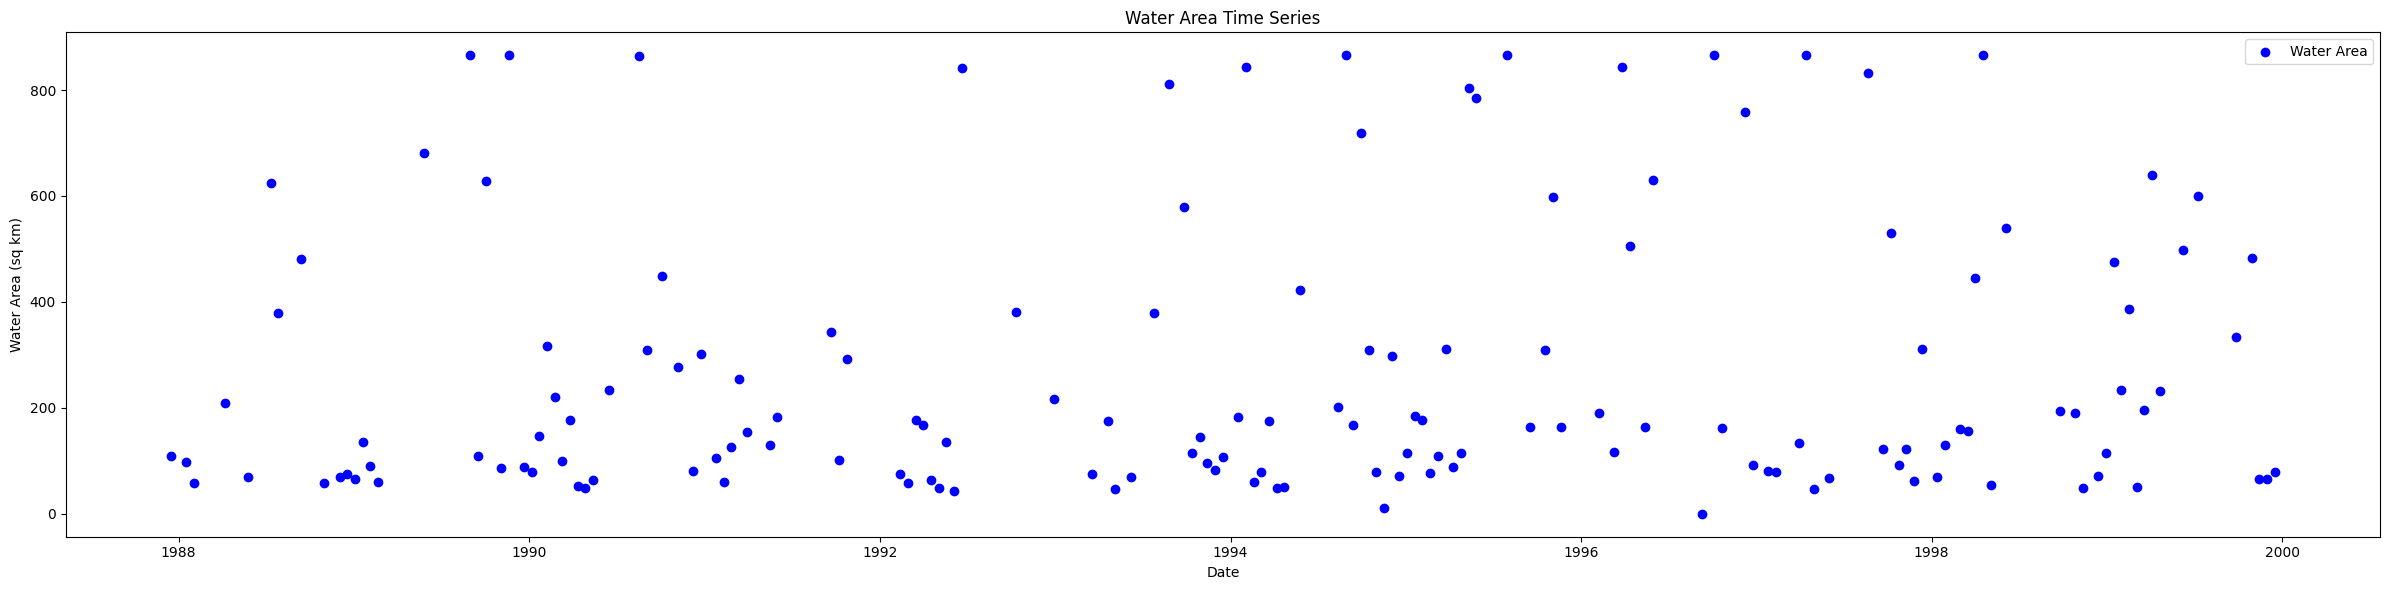

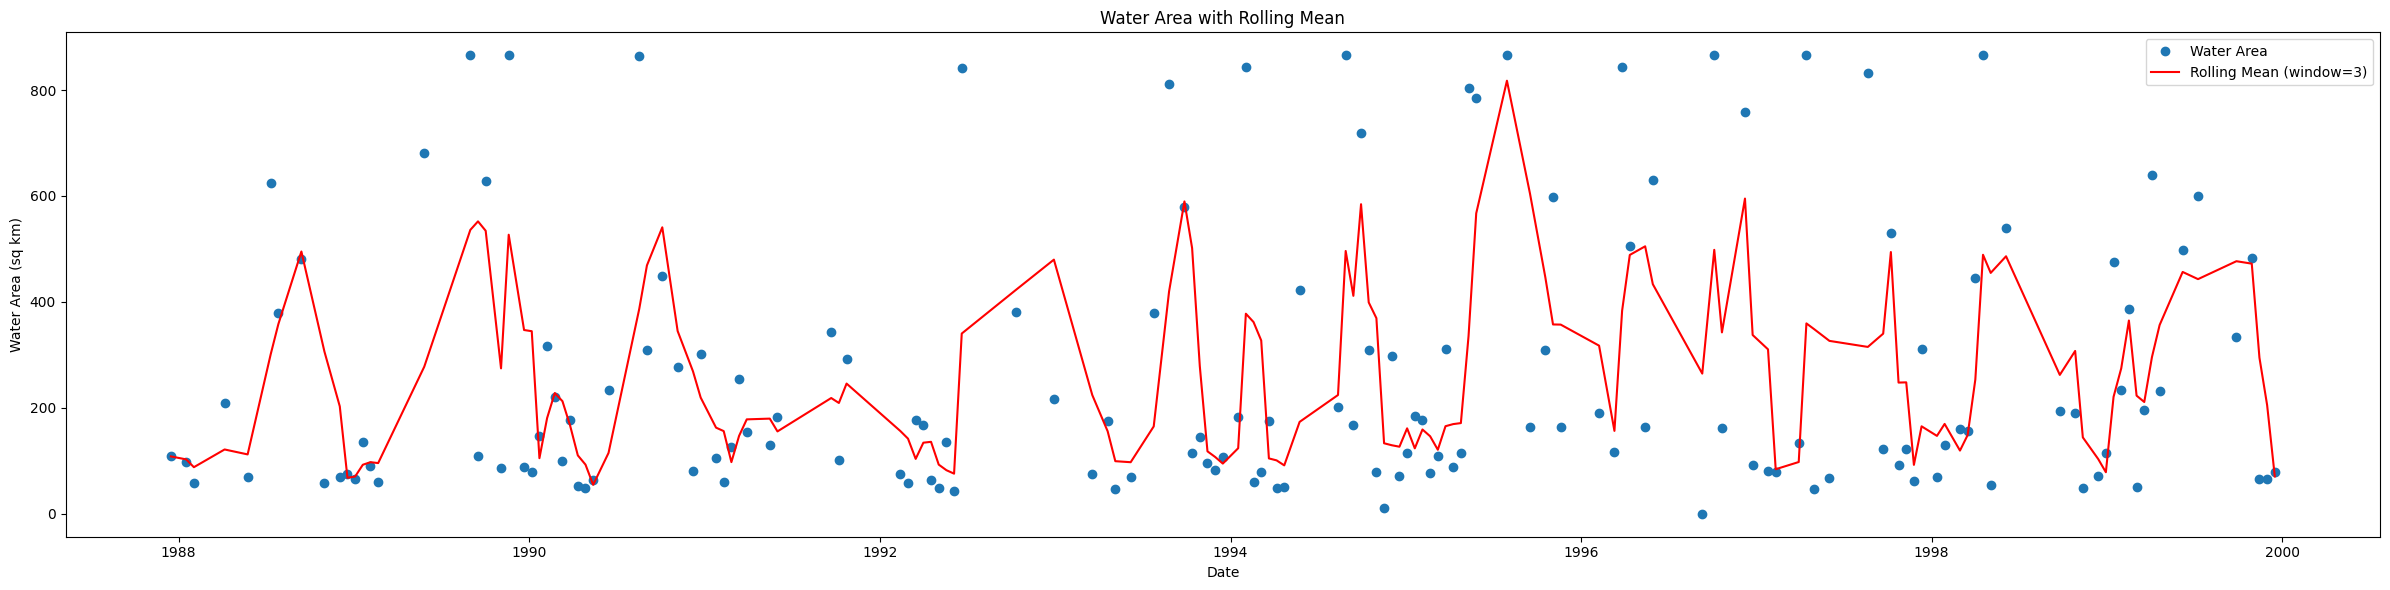

In [113]:
# df_ndwi に 'date' 列と 'water_area_sqkm' 列がある前提
df = df_mndwi.copy()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# 元データのプロット
plt.figure(figsize=(24,6))
plt.scatter(df.index, df['water_area_sqkm'], label='Water Area', color='blue')
plt.title('Water Area Time Series')
plt.xlabel('Date')
plt.ylabel('Water Area (sq km)')
plt.legend()
plt.tight_layout()
plt.show()

# 移動平均（例：3シーンのローリング平均）を計算してプロット
df['rolling_mean'] = df['water_area_sqkm'].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(24,6))
plt.plot(df.index, df['water_area_sqkm'], marker='o', linestyle='', label='Water Area')
plt.plot(df.index, df['rolling_mean'], color='red', label='Rolling Mean (window=3)')
plt.title('Water Area with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Water Area (sq km)')
plt.legend()
plt.tight_layout()
plt.show()

### 季節分解 (Seasonal Decomposition)

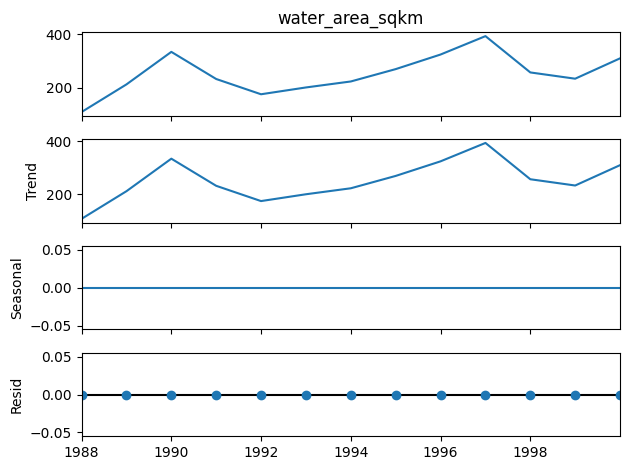

In [114]:
# 数値カラム 'water_area_sqkm' のみを選択して、年毎（'YE'）にリサンプリング
df_yearly = df[['water_area_sqkm']].resample('YE').mean()

# 季節分解（ここでは加法モデルを使用）
decomposition = seasonal_decompose(df_yearly['water_area_sqkm'], model='additive')
decomposition.plot()
plt.tight_layout()
plt.show()

### 線形回帰によるトレンド推定

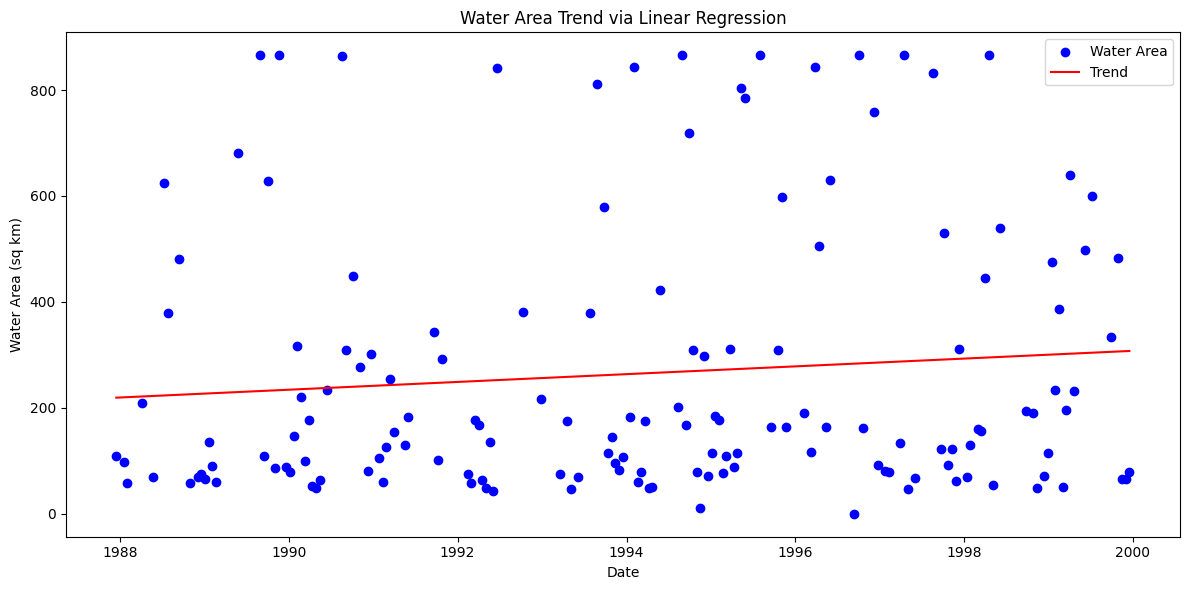

In [115]:
# 日付を数値に変換（例: オーディナル値）
df['ordinal'] = df.index.map(pd.Timestamp.toordinal)

X = df[['ordinal']]
y = df['water_area_sqkm']

model = LinearRegression()
model.fit(X, y)

# トレンドの予測値を計算
df['trend'] = model.predict(X)

plt.figure(figsize=(12,6))
plt.scatter(df.index, y, label='Water Area', color='blue')
plt.plot(df.index, df['trend'], color='red', label='Trend')
plt.title('Water Area Trend via Linear Regression')
plt.xlabel('Date')
plt.ylabel('Water Area (sq km)')
plt.legend()
plt.tight_layout()
plt.show()

### トレンド検定 (Mann-Kendall 検定)

In [116]:
# df_yearly など、一定の頻度にリサンプリングされた時系列データに対して実施
result = mk.original_test(df_yearly['water_area_sqkm'].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.05858757531048897, z=1.8912755158683454, Tau=0.41025641025641024, s=32.0, var_s=268.6666666666667, slope=10.68320755851571, intercept=169.50092069299646)
